In [27]:
import numpy as np
import sympy 
import matplotlib.pyplot as plt

In [28]:
class func1:
    def __init__(self):
        self.x_sym, self.y_sym = sympy.symbols('x y', real=True)

    def f(self, x, y):
        return 5 * (x - 3)**4 + 7 * (y - 9)**2
    
    def dx(self, x, y):
        df_dx = sympy.diff(self.f(self.x_sym, self.y_sym), self.x_sym)
        return df_dx.subs({self.x_sym: x, self.y_sym: y})
    
    def dy(self, x, y):
        df_dy = sympy.diff(self.f(self.x_sym, self.y_sym), self.y_sym)
        return df_dy.subs({self.x_sym: x, self.y_sym: y})
    
    
class func2:
    def __init__(self):
        self.x_sym, self.y_sym = sympy.symbols('x y', real=True)
    
    def f(self, x, y):
        return sympy.Max(x - 3, 0) + 7 * sympy.Abs(y - 9)
    
    def dx(self, x, y):
        df_dx = sympy.diff(self.f(self.x_sym, self.y_sym), self.x_sym)
        return df_dx.subs({self.x_sym: x, self.y_sym: y})
    
    def dy(self, x, y):
        df_dy = sympy.diff(self.f(self.x_sym, self.y_sym), self.y_sym)
        return df_dy.subs({self.x_sym: x, self.y_sym: y})

## Question 1 ##
#### a) Polyak ####

In [29]:
def polyak_GD(func, x0, y0, f_star=0, epsilon=0.0001, max_iters=1000, tol=100):
    # Initialize x,y and path and f(x,y) lists
    x, y = x0, y0
    path = [(x, y)]
    f_vals = []
    
    # Implement formula to find alpha and update at each step.
    for i in range(max_iters):
        df_dx = func.dx(x, y)
        df_dy = func.dy(x, y)
        alpha = (func.f(x, y) - f_star) / (df_dx**2 + df_dy**2 + epsilon)
        # Update x and y based on polyak step - optimal alpha
        x -= alpha * df_dx 
        y -= alpha * df_dy
        # Append both (x, y) point and f value to lists
        path.append((x, y))
        f_vals.append(func.f(x, y))
        
        # Check stopping conditions for alpha too high or too low
        if alpha > tol:
            print(f"Stopping after {i} Iterations as alpha too large")
            return path, f_vals
        if sympy.sqrt(func.dx(x, y)**2 + func.dy(x, y)**2) < epsilon:
            return path, f_vals


    print(f"No sufficient convergence by iteration {max_iters}\nFinished at (x, y): ({x:0.4f}, {y:0.4f})")
    return path, f_vals


#### b) RMSprop ####

In [30]:
def rmsprop(func, x0, y0, alpha0, beta, epsilon=0.0001, max_iters=1000):
    # Initialize x,y, sums and path,f(x,y) lists
    x, y = x0, y0
    sum_dx = 0
    sum_dy = 0
    path = [(x, y)]
    f_vals = []

    for t in range(1, max_iters + 1):
        # Take gradients for current x, y
        grad_x = func.dx(x, y)
        grad_y = func.dy(x, y)

        # Update denominator for x and y using the following
        sum_dx = beta * sum_dx + (1 - beta) * grad_x**2
        sum_dy = beta * sum_dy + (1 - beta) * grad_y**2

        # Compute the step sizes for x and y
        step_size_x = alpha0 / sympy.sqrt(sum_dx + epsilon)
        step_size_y = alpha0 / sympy.sqrt(sum_dy + epsilon)

        # Update x and y
        x -= step_size_x * grad_x
        y -= step_size_y * grad_y

        path.append((x, y))
        f_vals.append(func.f(x, y))

    return path, f_vals

#### c) Heavy Ball ####

In [31]:
def heavy_ball(func, x0, y0, alpha, beta, num_iters=1000, tol=1e-5, stopping=True):
    # Initialize x,y, momentum variables and path,f(x,y) lists
    x, y = x0, y0 
    ux, uy = 0, 0
    path = [(x, y)] 
    f_vals = []
    
    for i in range(num_iters):
        # Take gradients for current x, y
        grad_x = func.dx(x, y)
        grad_y = func.dy(x, y)
        
        # Update momentum variable with current and past momentum
        ux = beta * ux + alpha * grad_x
        uy = beta * uy + alpha * grad_y
        
        # Update x and y
        x -= ux
        y -= uy
        
        path.append((x, y))  # Store the new values
        f_vals.append(func.f(x, y))
        
        if func.f(x, y) > 1e20:
            break
        
        # Check if the norm of the gradient is below the tolerance
        if sympy.sqrt(grad_x**2 + grad_y**2) < tol and stopping == True:
            break
    
    return path, f_vals

#### d) Adam ####

In [32]:
def adam(func, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000):
    # Initialize x,y, momentum variables and path,f(x,y) lists
    x, y = x0, y0 
    m_x, m_y = 0, 0
    v_x, v_y = 0, 0
    path = [(x, y)] 
    f_vals = []
    
    for t in range(1, num_iters + 1):
        # Take gradients for current x, y
        grad_x = func.dx(x, y)
        grad_y = func.dy(x, y)
        # Update momentum variable for gradient
        m_x = beta1 * m_x + (1 - beta1) * grad_x
        m_y = beta1 * m_y + (1 - beta1) * grad_y
       # Update momentum variable for squared gradient
        v_x = beta2 * v_x + (1 - beta2) * grad_x**2
        v_y = beta2 * v_y + (1 - beta2) * grad_y**2
        # Compute bias-corrected estimates
        m_x_hat = m_x / (1 - beta1**t)
        m_y_hat = m_y / (1 - beta1**t)

        v_x_hat = v_x / (1 - beta2**t)
        v_y_hat = v_y / (1 - beta2**t)

        # Update variables
        x -= alpha * m_x_hat / (sympy.sqrt(v_x_hat) + epsilon)
        y -= alpha * m_y_hat / (sympy.sqrt(v_y_hat) + epsilon)
        if func.f(x, y) > 1e20:
            break

        path.append((x, y)) 
        f_vals.append(func.f(x, y))
    
    return path, f_vals

## Question 2 ##

In [33]:
function1 = func1()
function2 = func2()

x0 = 1
y0 = 1

for function in [function1, function2]:
    polyak_path, _ = polyak_GD(function, x0, y0)
    rms_path, _ = rmsprop(function, x0, y0, alpha0=0.1, beta=0.9)
    hb_path, _ = heavy_ball(function, x0, y0, alpha=0.01, beta=0.9)
    adam_path, _ = adam(function, x0, y0, alpha=0.01,beta1=0.9, beta2=0.9)

    print(f"Convergence from polyak at (x,y) = ({polyak_path[-1][0]:0.4f}, {polyak_path[-1][1]:0.4f})")
    print(f"Convergence from RMSProp at (x,y) = ({rms_path[-1][0]:0.4f}, {rms_path[-1][1]:0.4f})")
    print(f"Convergence from Heavy Ball at (x,y) = ({hb_path[-1][0]:0.4f}, {hb_path[-1][1]:0.4f})")
    print(f"Convergence from Adam at (x,y) = ({adam_path[-1][0]:0.4f}, {adam_path[-1][1]:0.4f})\n")

No convergence by iteration 1000
Finished at (x, y): (3.0236, 9.0000)
Convergence from polyak at (x,y) = (3.0236, 9.0000)
Convergence from RMSProp at (x,y) = (2.9983, 9.0000)
Convergence from Heavy Ball at (x,y) = (2.9849, 9.0000)
Convergence from Adam at (x,y) = (2.9999, 9.0003)

Convergence from polyak at (x,y) = (1.0000, 9.0000)
Convergence from RMSProp at (x,y) = (1.0000, 8.9139)
Convergence from Heavy Ball at (x,y) = (1.0000, 8.9357)
Convergence from Adam at (x,y) = (1.0000, 9.0029)



#### a) RMSProp ####

In [34]:
def RMS_grid_search(func, x0, y0, alphas, betas, epsilon=1e-4, num_iters=1000):
    best_alpha = None
    best_beta = None
    best_f_value = 1e9
    
    for alpha in alphas:
        for beta in betas:
            _, f_vals = rmsprop(func, x0, y0, alpha, beta, epsilon, num_iters)
            f_value = f_vals[-1]
            if f_value < best_f_value:
                best_f_value = f_value
                best_alpha = alpha
                best_beta = beta
    
    return best_alpha, best_beta, best_f_value

Grid Search for RMSProp

In [35]:
alphas = np.logspace(-3, 2, 5) 
betas = np.linspace(0.25, 0.99, 5)

# Perform the grid search
best_alpha, best_beta, best_f_value = RMS_grid_search(function1, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.3162
Best beta: 0.9900


In [36]:
alphas = np.linspace(0.5, 2, 5)  
betas = np.linspace(0.98, 0.999, 5)

# Perform the grid search
best_alpha, best_beta, best_f_value = RMS_grid_search(function1, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.5000
Best beta: 0.9800


Plot Path for RMSProp

In [37]:
alphas = np.logspace(-3, 2, 5) 
betas = np.linspace(0.25, 0.95, 5)
paths_1 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[0] for beta in betas] for alpha in alphas]
f_vals_1 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[1] for beta in betas] for alpha in alphas]

alphas = np.linspace(0.5, 2, 5)  
betas = np.linspace(0.98, 0.9999, 5)
paths_2 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[0] for beta in betas] for alpha in alphas]
f_vals_2 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[1] for beta in betas] for alpha in alphas]

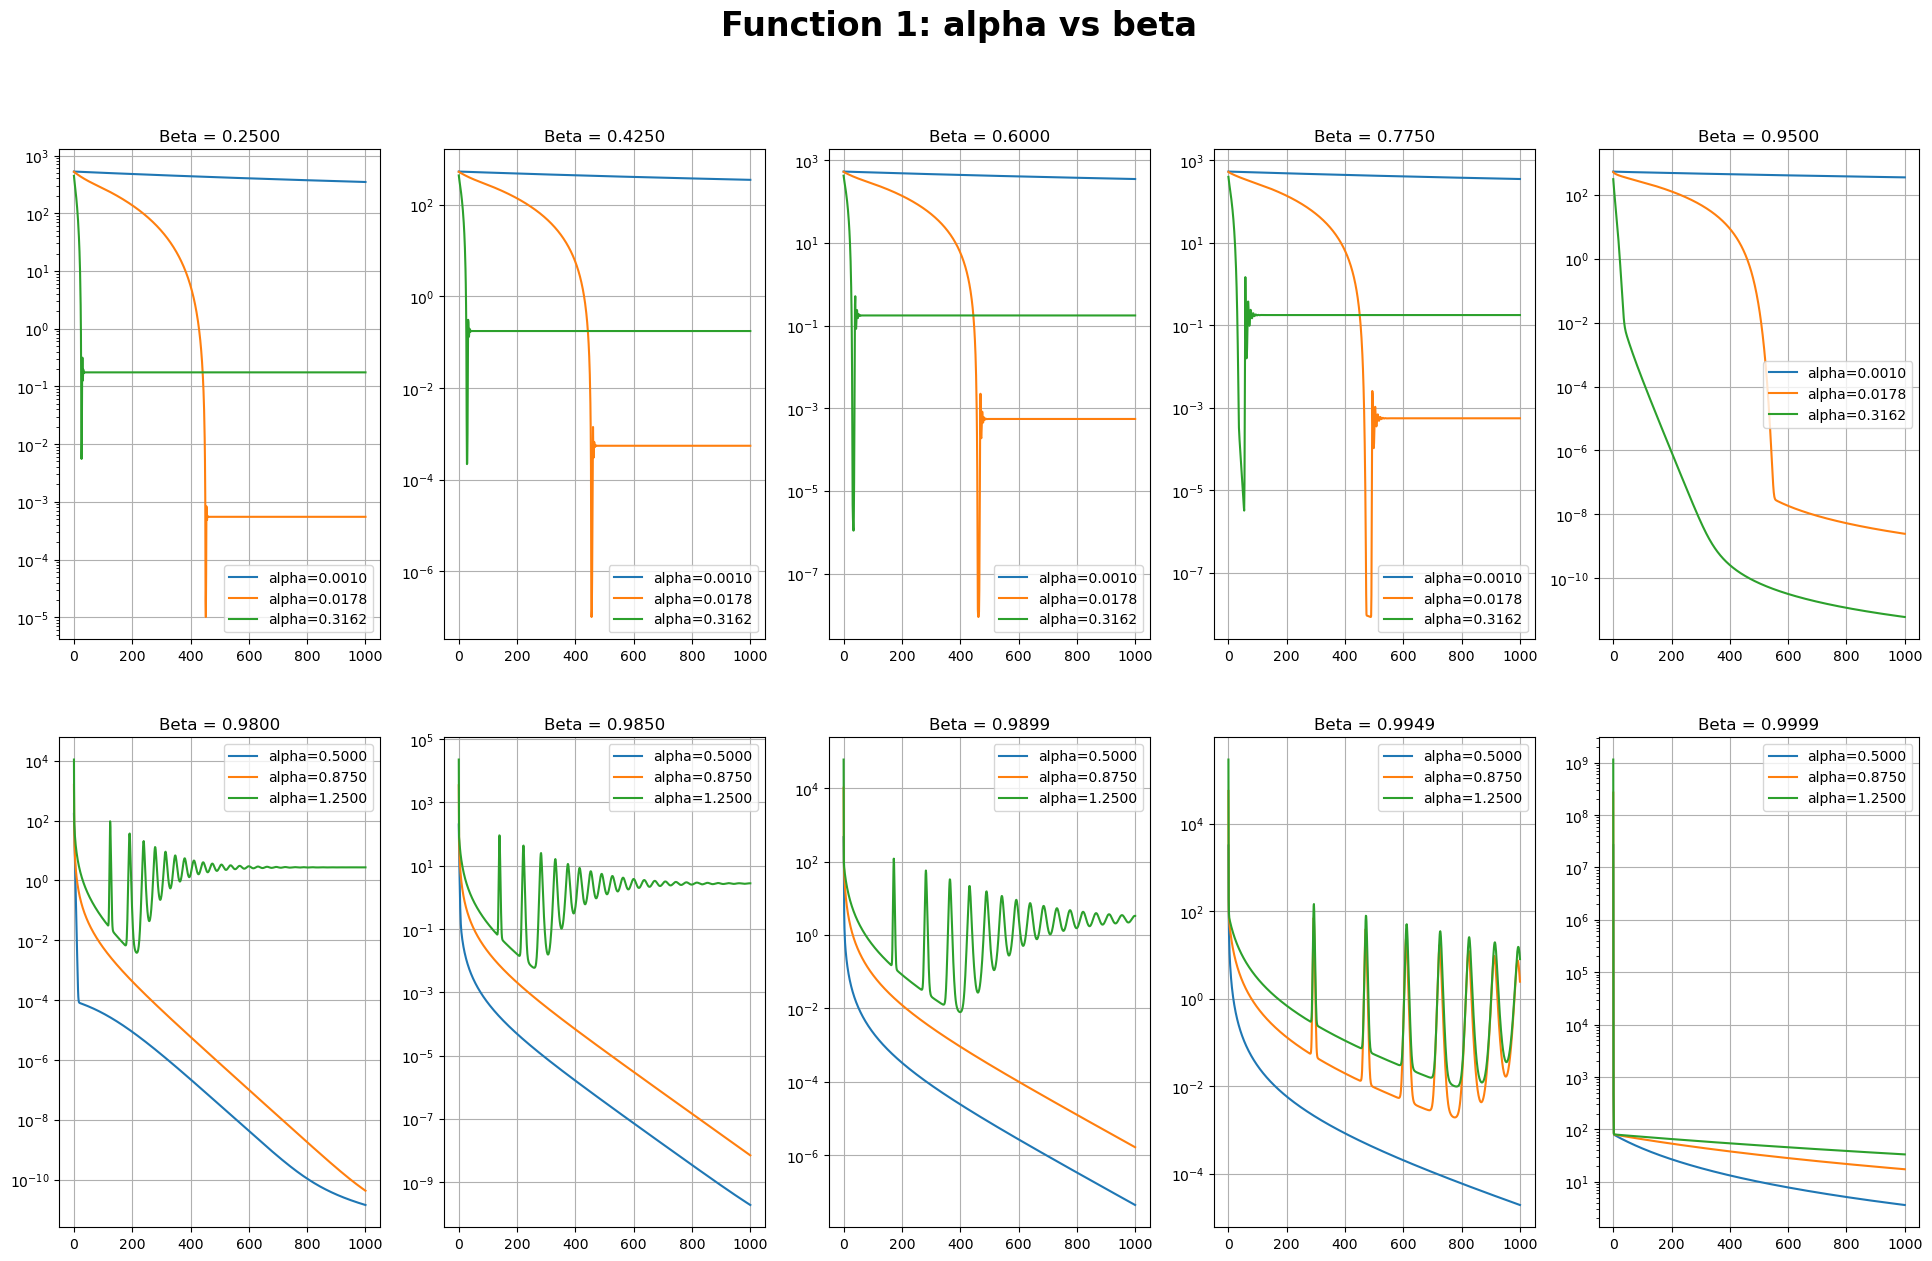

In [38]:
x = np.linspace(0, 1000, 1000)
alphas = np.logspace(-3, 2, 5) 
betas = np.linspace(0.25, 0.95, 5)

plt.figure(figsize=(24, 14))
plt.suptitle("Function 1: alpha vs beta", fontsize=24, fontweight='bold')

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.semilogy(x, f_vals_1[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(x, f_vals_1[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(x, f_vals_1[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)


alphas = np.linspace(0.5, 2, 5)  
betas = np.linspace(0.98, 0.9999, 5)
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.semilogy(x, f_vals_2[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(x, f_vals_2[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(x, f_vals_2[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

plt.show()  # This will display the figure if it's not already displayed

In [39]:
alphas = np.logspace(-3, 1, 5) 
betas = np.linspace(0.25, 0.95, 5)

# Perform the grid search
best_alpha, best_beta, best_f_value = RMS_grid_search(function2, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 1.0000
Best beta: 0.9500


In [40]:
alphas = np.linspace(0.5, 1.5, 5) 
betas = np.linspace(0.85, 0.92, 5)

# Perform the grid search
best_alpha, best_beta, best_f_value = RMS_grid_search(function2, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.7500
Best beta: 0.8675


In [41]:
alphas = np.logspace(-3, 1,3)
betas = np.linspace(0.25, 0.95, 5)
paths_1 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[0] for beta in betas] for alpha in alphas]
f_vals_1 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[1] for beta in betas] for alpha in alphas]

alphas = np.linspace(0.5, 1.5, 3) 
betas = np.linspace(0.85, 0.92, 5)
paths_2 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[0] for beta in betas] for alpha in alphas]
f_vals_2 = [[rmsprop(function1, x0, y0, alpha0=alpha, beta=beta)[1] for beta in betas] for alpha in alphas]

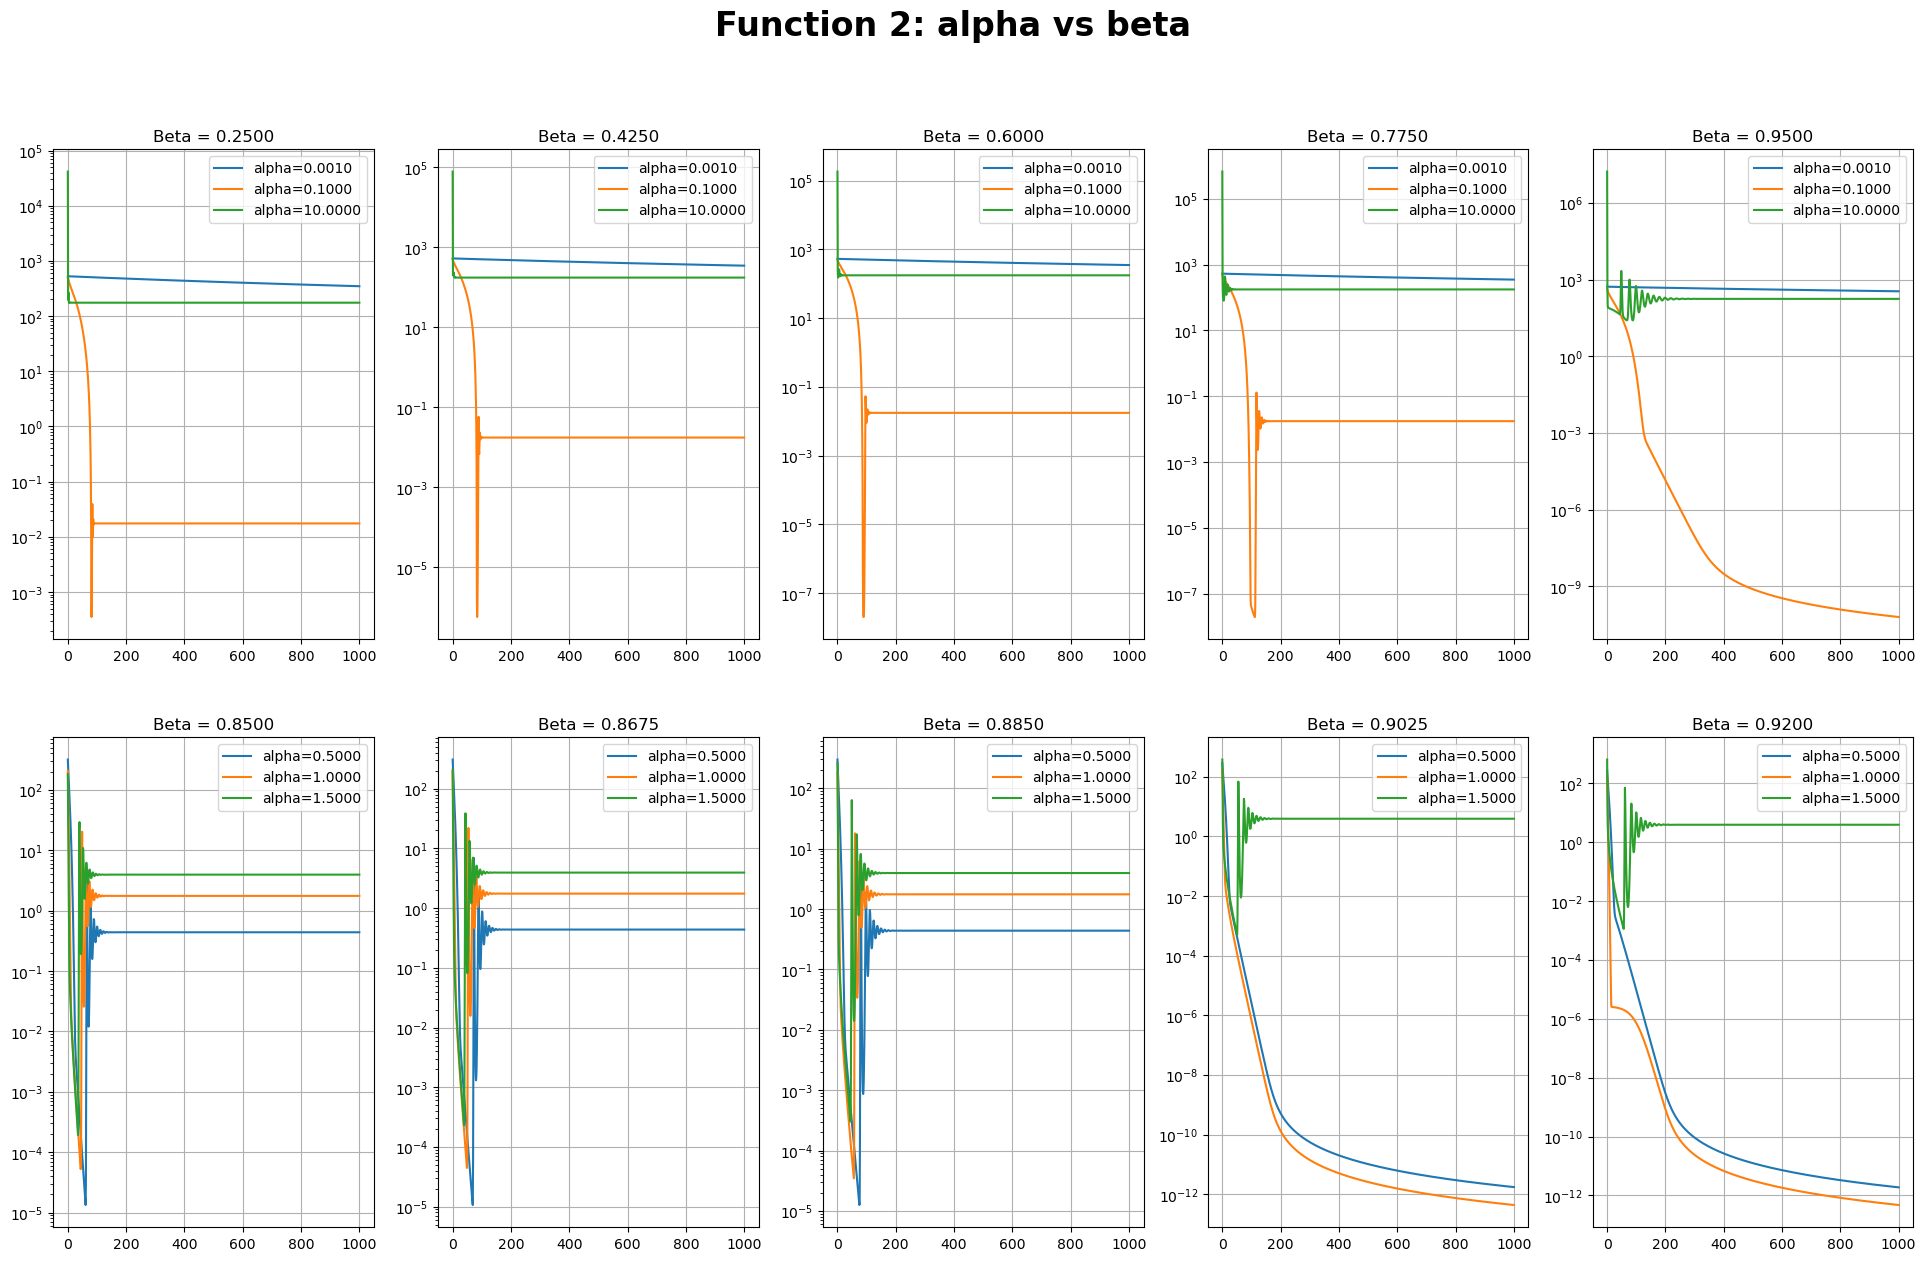

In [42]:
x = np.linspace(0, 1000, 1000)
alphas = np.logspace(-3, 1, 3) 
betas = np.linspace(0.25, 0.95, 5)
plt.figure(figsize=(24, 14))
plt.suptitle("Function 2: alpha vs beta", fontsize=24, fontweight='bold')

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.semilogy(x, f_vals_1[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(x, f_vals_1[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(x, f_vals_1[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)


alphas = np.linspace(0.5, 1.5, 3) 
betas = np.linspace(0.85, 0.92, 5)
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.semilogy(x, f_vals_2[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(x, f_vals_2[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(x, f_vals_2[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

plt.show()  # This will display the figure if it's not already displayed

#### b) Heavy Ball ####

In [43]:
def HB_grid_search(func, x0, y0, alphas, betas, tol=1e-4, num_iters=1000):
    best_alpha = None
    best_beta = None
    best_f_value = 1e9
    
    for alpha in alphas:
        for beta in betas:
            _, f_vals = heavy_ball(func, x0, y0, alpha, beta, num_iters=num_iters, tol=tol, stopping=False)
            f_value = f_vals[-1]
            if f_value < best_f_value:
                best_f_value = f_value
                best_alpha = alpha
                best_beta = beta
    
    return best_alpha, best_beta, best_f_value

In [44]:
alphas = np.logspace(-5, -2, 6) 
betas = np.linspace(0.25, 0.95, 6)

# Perform the grid search
best_alpha, best_beta, best_f_value = HB_grid_search(function1, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.0100
Best beta: 0.9500


In [45]:
alphas = np.linspace(0.001, 0.02, 6) 
betas = np.linspace(0.91, 0.99, 6)

# Perform the grid search
best_alpha, best_beta, best_f_value = HB_grid_search(function1, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.0048
Best beta: 0.9420


In [46]:
alphas = np.logspace(-5, -2, 3) 
betas = np.linspace(0.25, 0.95, 6)
paths_1 = [[heavy_ball(function1, x0, y0, alpha=alpha, beta=beta, stopping=True)[0] for beta in betas] for alpha in alphas]
f_vals_1 = [[heavy_ball(function1, x0, y0, alpha=alpha, beta=beta, stopping=True)[1] for beta in betas] for alpha in alphas]

alphas = np.linspace(0.001, 0.01, 3) 
betas = np.linspace(0.91, 0.99, 6)
paths_2 = [[heavy_ball(function1, x0, y0, alpha=alpha, beta=beta, stopping=True)[0] for beta in betas] for alpha in alphas]
f_vals_2 = [[heavy_ball(function1, x0, y0, alpha=alpha, beta=beta, stopping=True)[1] for beta in betas] for alpha in alphas]

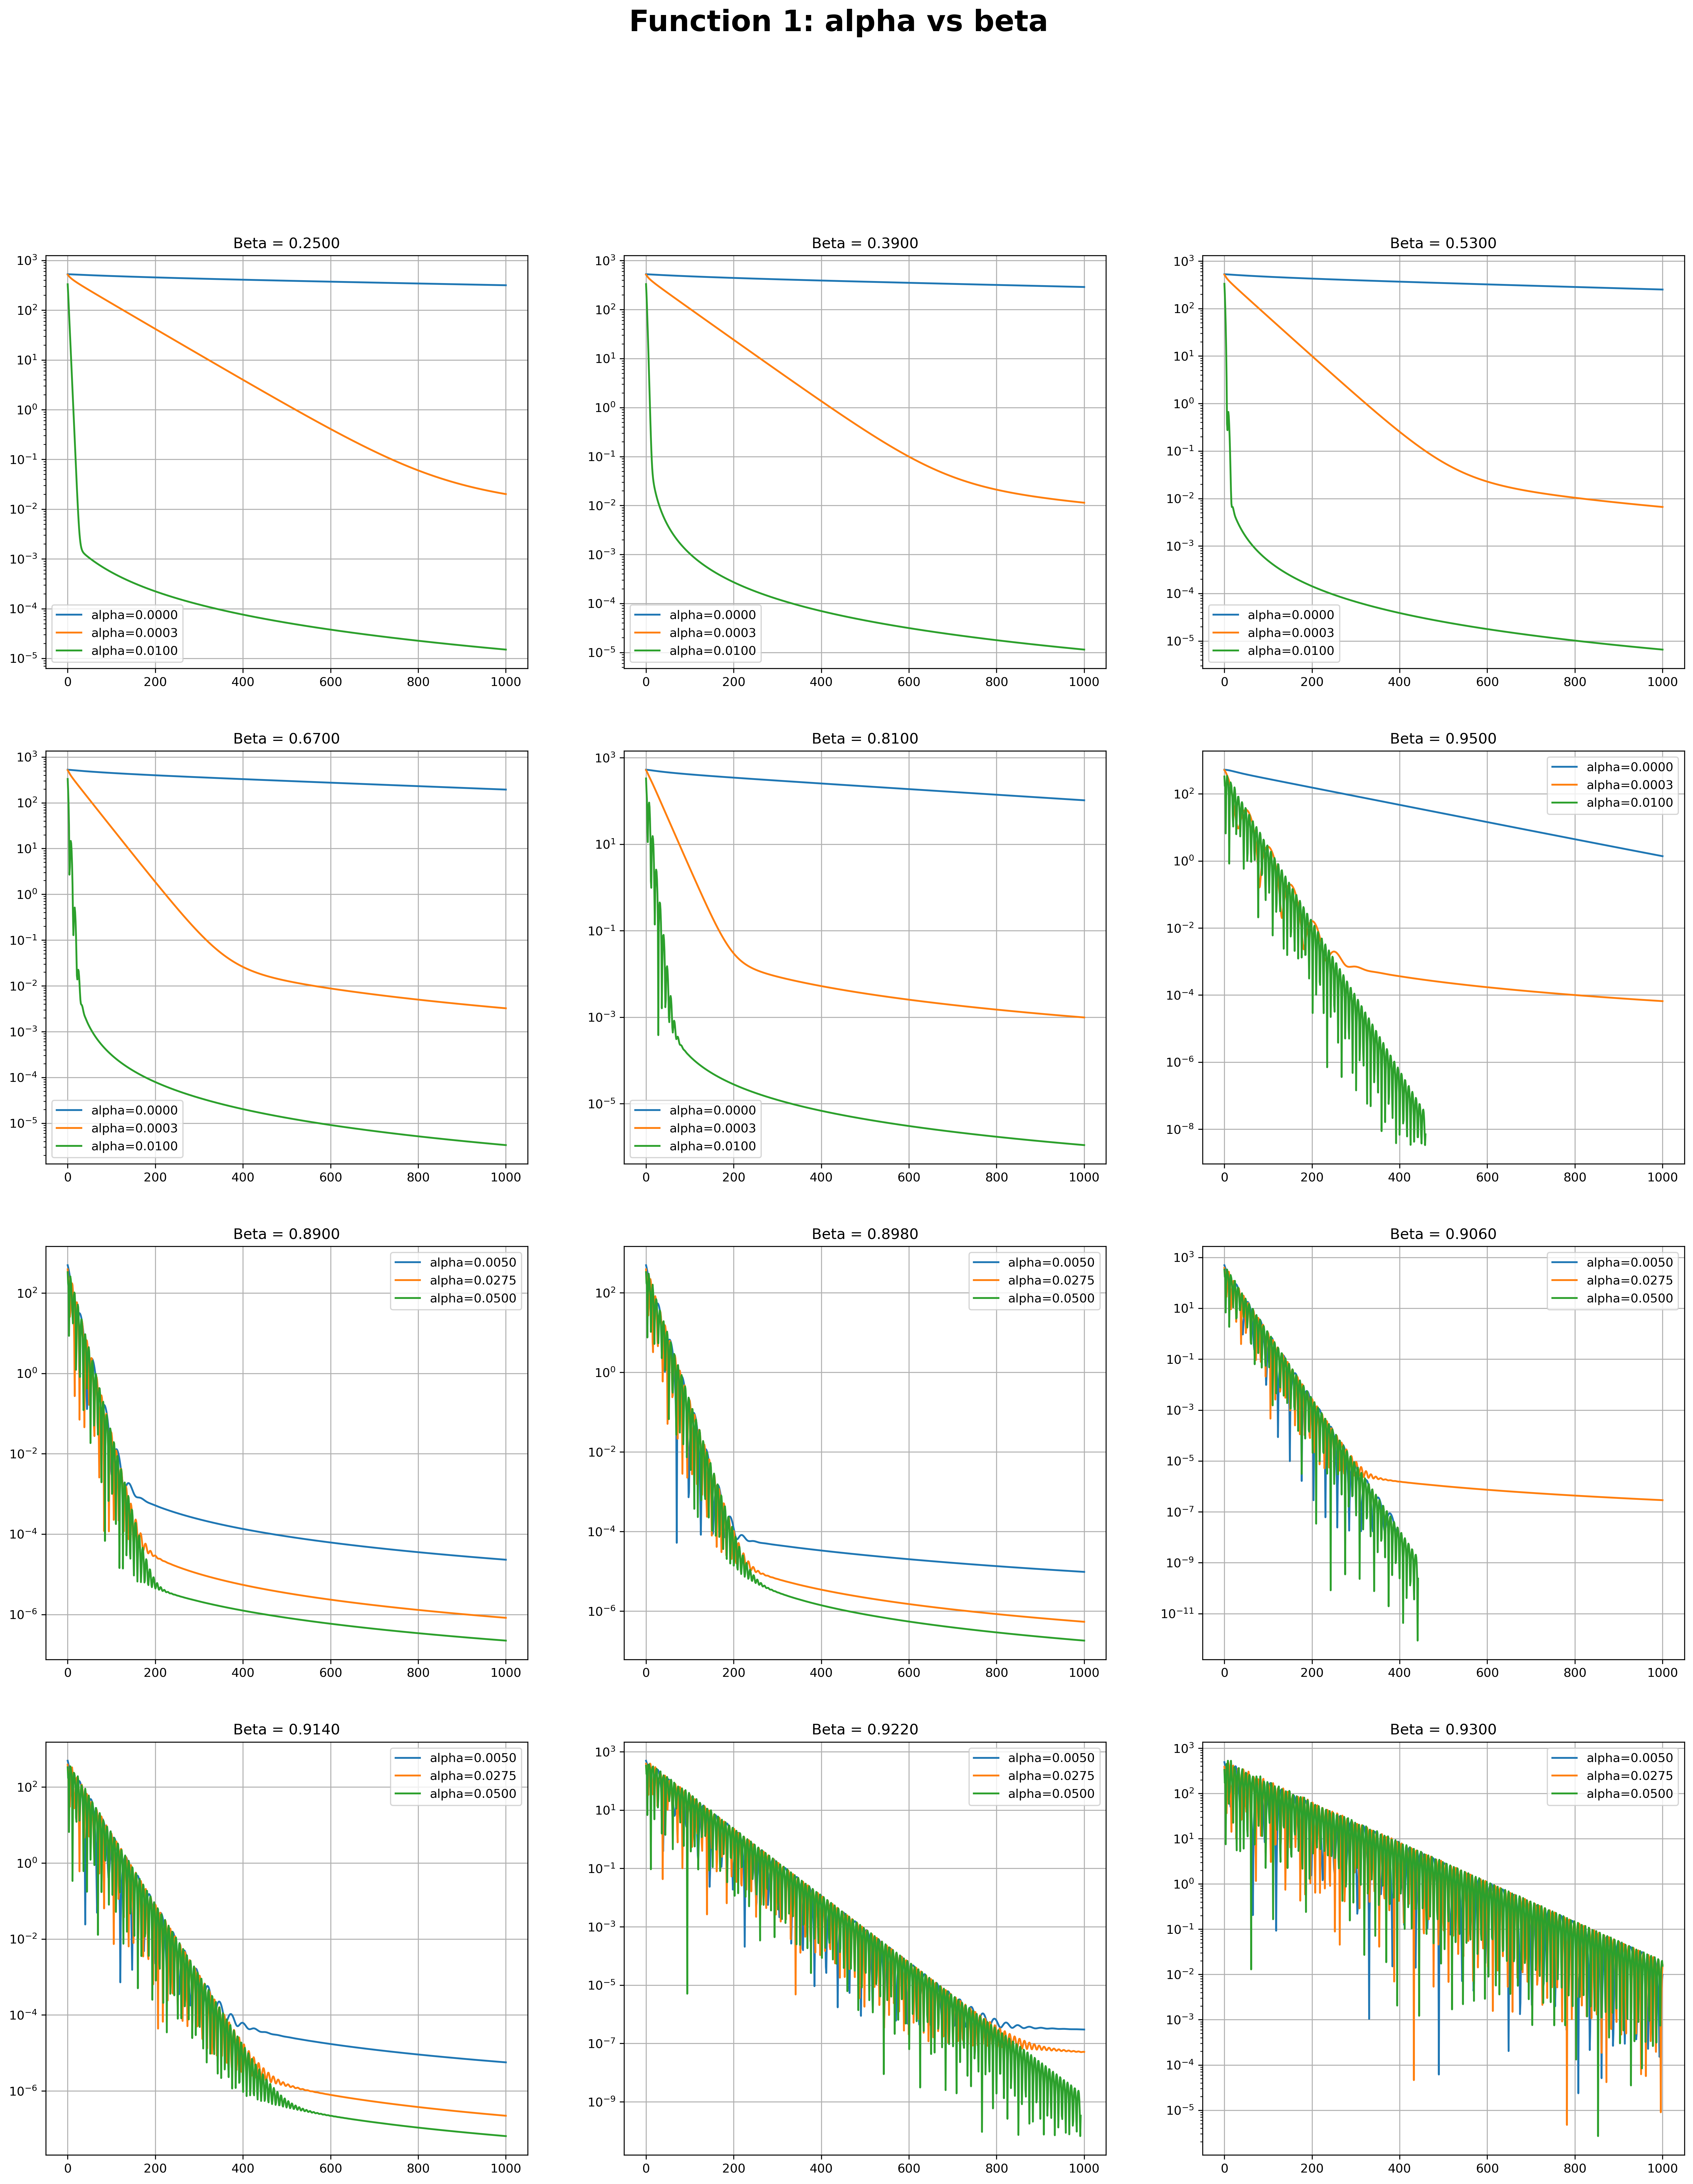

In [47]:
alphas = np.logspace(-5, -2, 3) 
betas = np.linspace(0.25, 0.95, 6)

plt.figure(figsize=(24, 28), dpi=300)
plt.suptitle("Function 1: alpha vs beta", fontsize=24, fontweight='bold')

for i in range(6):
    plt.subplot(4, 3, i+1)
    plt.semilogy(np.linspace(0, len(f_vals_1[0][i]), len(f_vals_1[0][i])), f_vals_1[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[1][i]), len(f_vals_1[1][i])), f_vals_1[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[2][i]), len(f_vals_1[2][i])), f_vals_1[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)
    


alphas = np.linspace(0.005, 0.05, 3) 
betas = np.linspace(0.89, 0.93, 6)
for i in range(6):
    plt.subplot(4, 3, i+7)
    plt.semilogy(np.linspace(0, len(f_vals_2[0][i]), len(f_vals_2[0][i])), f_vals_2[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_2[1][i]), len(f_vals_2[1][i])), f_vals_2[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_2[2][i]), len(f_vals_2[2][i])), f_vals_2[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

plt.show()  # This will display the figure if it's not already displayed

In [48]:
alphas = np.logspace(-5, -2, 6) 
betas = np.linspace(0.25, 0.95, 6)

# Perform the grid search
best_alpha, best_beta, best_f_value = HB_grid_search(function2, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.0025
Best beta: 0.6700


In [49]:
alphas = np.linspace(0.0001, 0.001, 6) 
betas = np.linspace(0.82, 0.86, 6)

# Perform the grid search
best_alpha, best_beta, best_f_value = HB_grid_search(function2, x0, y0, alphas, betas)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta: {best_beta:0.4f}")

Best alpha: 0.0005
Best beta: 0.8520


In [50]:
alphas = np.logspace(-5, -2, 3) 
betas = np.linspace(0.25, 0.95, 5)
paths_1 = [[heavy_ball(function2, x0, y0, alpha=alpha, beta=beta, stopping=False)[0] for beta in betas] for alpha in alphas]
f_vals_1 = [[heavy_ball(function2, x0, y0, alpha=alpha, beta=beta, stopping=False)[1] for beta in betas] for alpha in alphas]

alphas = np.linspace(0.0001, 0.001, 3) 
betas = np.linspace(0.82, 0.86, 5)
paths_2 = [[heavy_ball(function2, x0, y0, alpha=alpha, beta=beta, stopping=False)[0] for beta in betas] for alpha in alphas]
f_vals_2 = [[heavy_ball(function2, x0, y0, alpha=alpha, beta=beta, stopping=False)[1] for beta in betas] for alpha in alphas]

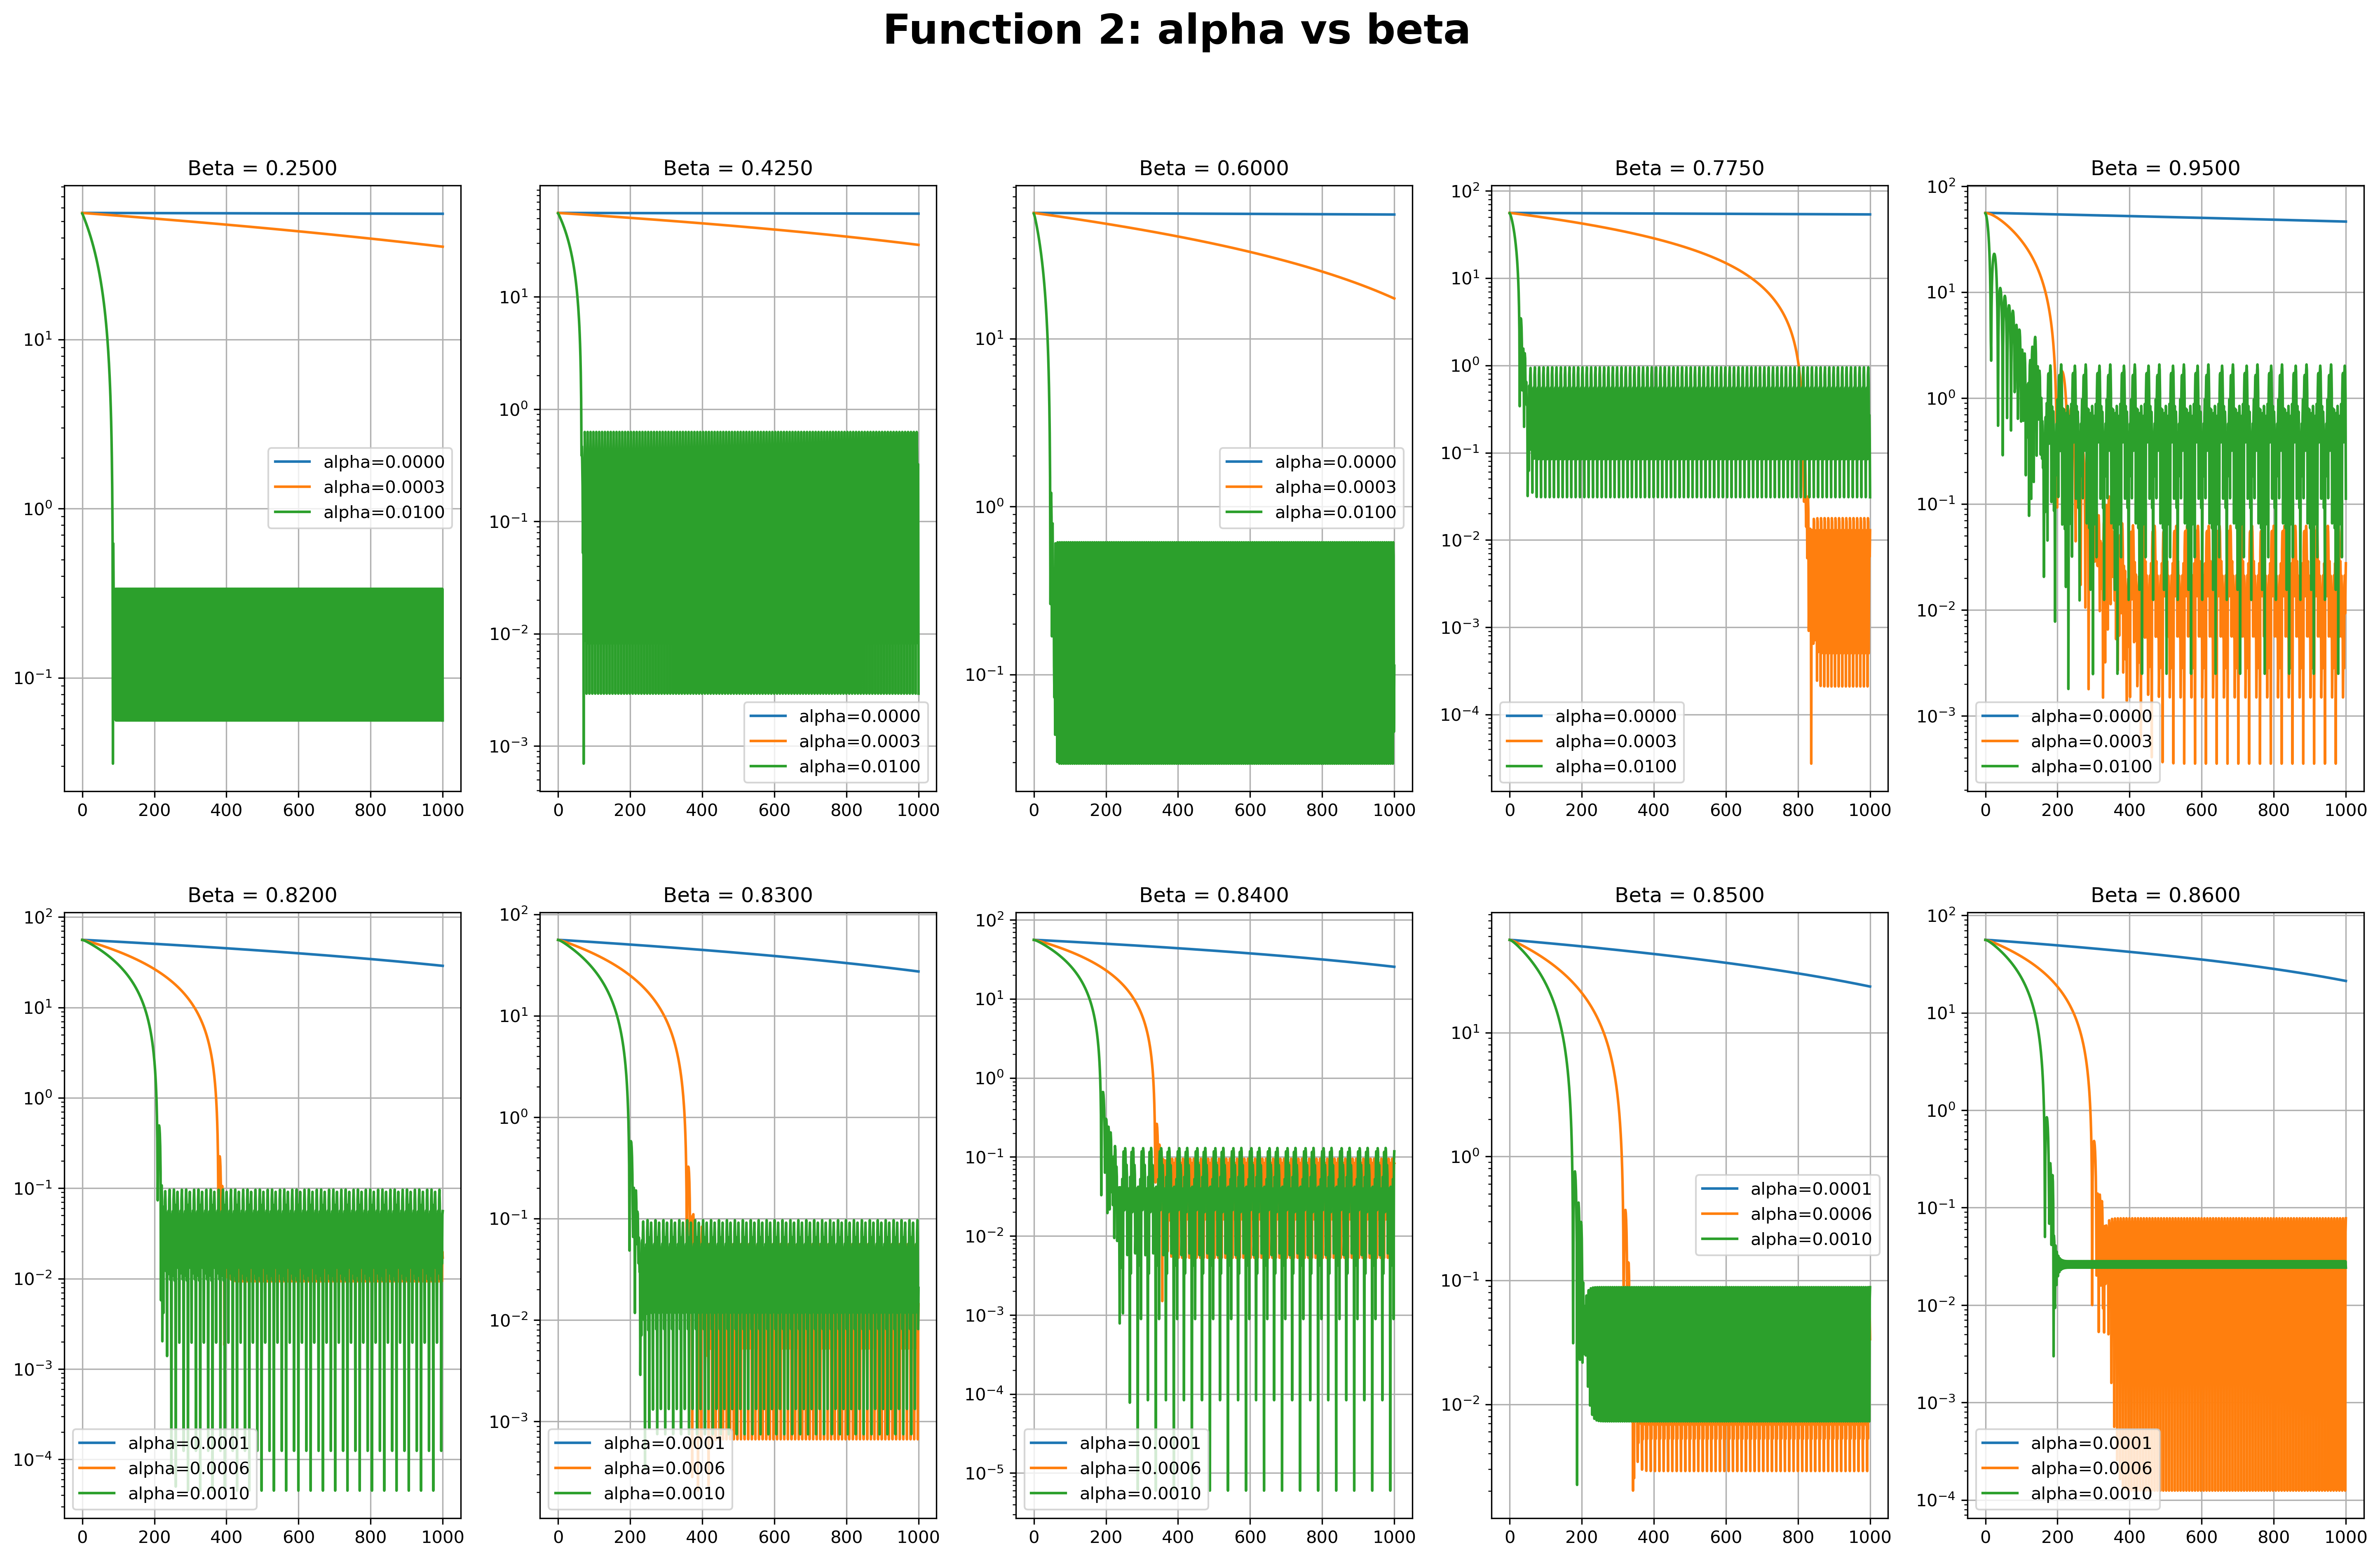

In [51]:
alphas = np.logspace(-5, -2, 3) 
betas = np.linspace(0.25, 0.95, 5)

plt.figure(figsize=(24, 14), dpi=300)
plt.suptitle("Function 2: alpha vs beta", fontsize=24, fontweight='bold')

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.semilogy(np.linspace(0, len(f_vals_1[0][i]), len(f_vals_1[0][i])), f_vals_1[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[1][i]), len(f_vals_1[1][i])), f_vals_1[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[2][i]), len(f_vals_1[2][i])), f_vals_1[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)
    

alphas = np.linspace(0.0001, 0.001, 3) 
betas = np.linspace(0.82, 0.86, 5)
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.semilogy(np.linspace(0, len(f_vals_2[0][i]), len(f_vals_2[0][i])), f_vals_2[0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_2[1][i]), len(f_vals_2[1][i])), f_vals_2[1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_2[2][i]), len(f_vals_2[2][i])), f_vals_2[2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta = {betas[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

plt.show()  # This will display the figure if it's not already displayed

#### c) Adam ####

In [70]:
def adam_grid_search(func, x0, y0, alphas, beta1s, beta2s, tol=1e-4, num_iters=1000):
    best_alpha = None
    best_beta1 = None
    best_best2 = None
    best_f_value = 1e9
    
    for alpha in alphas:
        for beta1 in beta1s:
            for beta2 in beta2s:
                _, f_vals =  adam(func, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000)
                f_value = f_vals[-1]
                if f_value < best_f_value:
                    best_f_value = f_value
                    best_alpha = alpha
                    best_beta1 = beta1
                    best_beta2 = beta2

    
    return best_alpha, best_beta1, best_beta2, best_f_value

In [72]:
alphas = np.logspace(-5, -2, 4) 
beta1s = np.linspace(0.25, 0.9999, 4)
beta2s = np.linspace(0.25, 0.9999, 4)

# Perform the grid search
best_alpha, best_beta1, best_beta2, best_f_value = adam_grid_search(function1, x0, y0, alphas, beta1s=beta1s, beta2s=beta2s)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta1: {best_beta1:0.4f}")
print(f"Best beta2: {best_beta2:0.4f}")

Best alpha: 0.0100
Best beta1: 0.5000
Best beta2: 0.5000


In [75]:
alphas = np.logspace(-5, -2, 4) 
beta1s = np.linspace(0.8, 92, 4)
beta2s = np.linspace(0.58, 0.68, 4)

# Perform the grid search
best_alpha, best_beta1, best_beta2, best_f_value = adam_grid_search(function1, x0, y0, alphas, beta1s=beta1s, beta2s=beta2s)

print(f"Best alpha: {best_alpha:0.4f}")
print(f"Best beta1: {best_beta1:0.4f}")
print(f"Best beta2: {best_beta2:0.4f}")

/var/folders/57/q42p3py10qx638l0f41_3dm80000gn/T/ipykernel_21479/1057781125.py:22: RuntimeWarning: overflow encountered in double_scalars
  m_x_hat = m_x / (1 - beta1**t)
/var/folders/57/q42p3py10qx638l0f41_3dm80000gn/T/ipykernel_21479/1057781125.py:23: RuntimeWarning: overflow encountered in double_scalars
  m_y_hat = m_y / (1 - beta1**t)


Best alpha: 0.0100
Best beta1: 0.8000
Best beta2: 0.6467


In [87]:
alphas = np.linspace(0.1, 0.5, 3) 
beta1s = np.linspace(0.8, 0.99, 4)
beta2s = np.linspace(0.8, 0.99, 4)
paths_1 = [[[adam(function1, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000)[0] for beta1 in beta1s] for beta2 in beta2s] for alpha in alphas]
f_vals_1 = [[[adam(function1, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000)[1] for beta1 in beta1s] for beta2 in beta2s] for alpha in alphas]

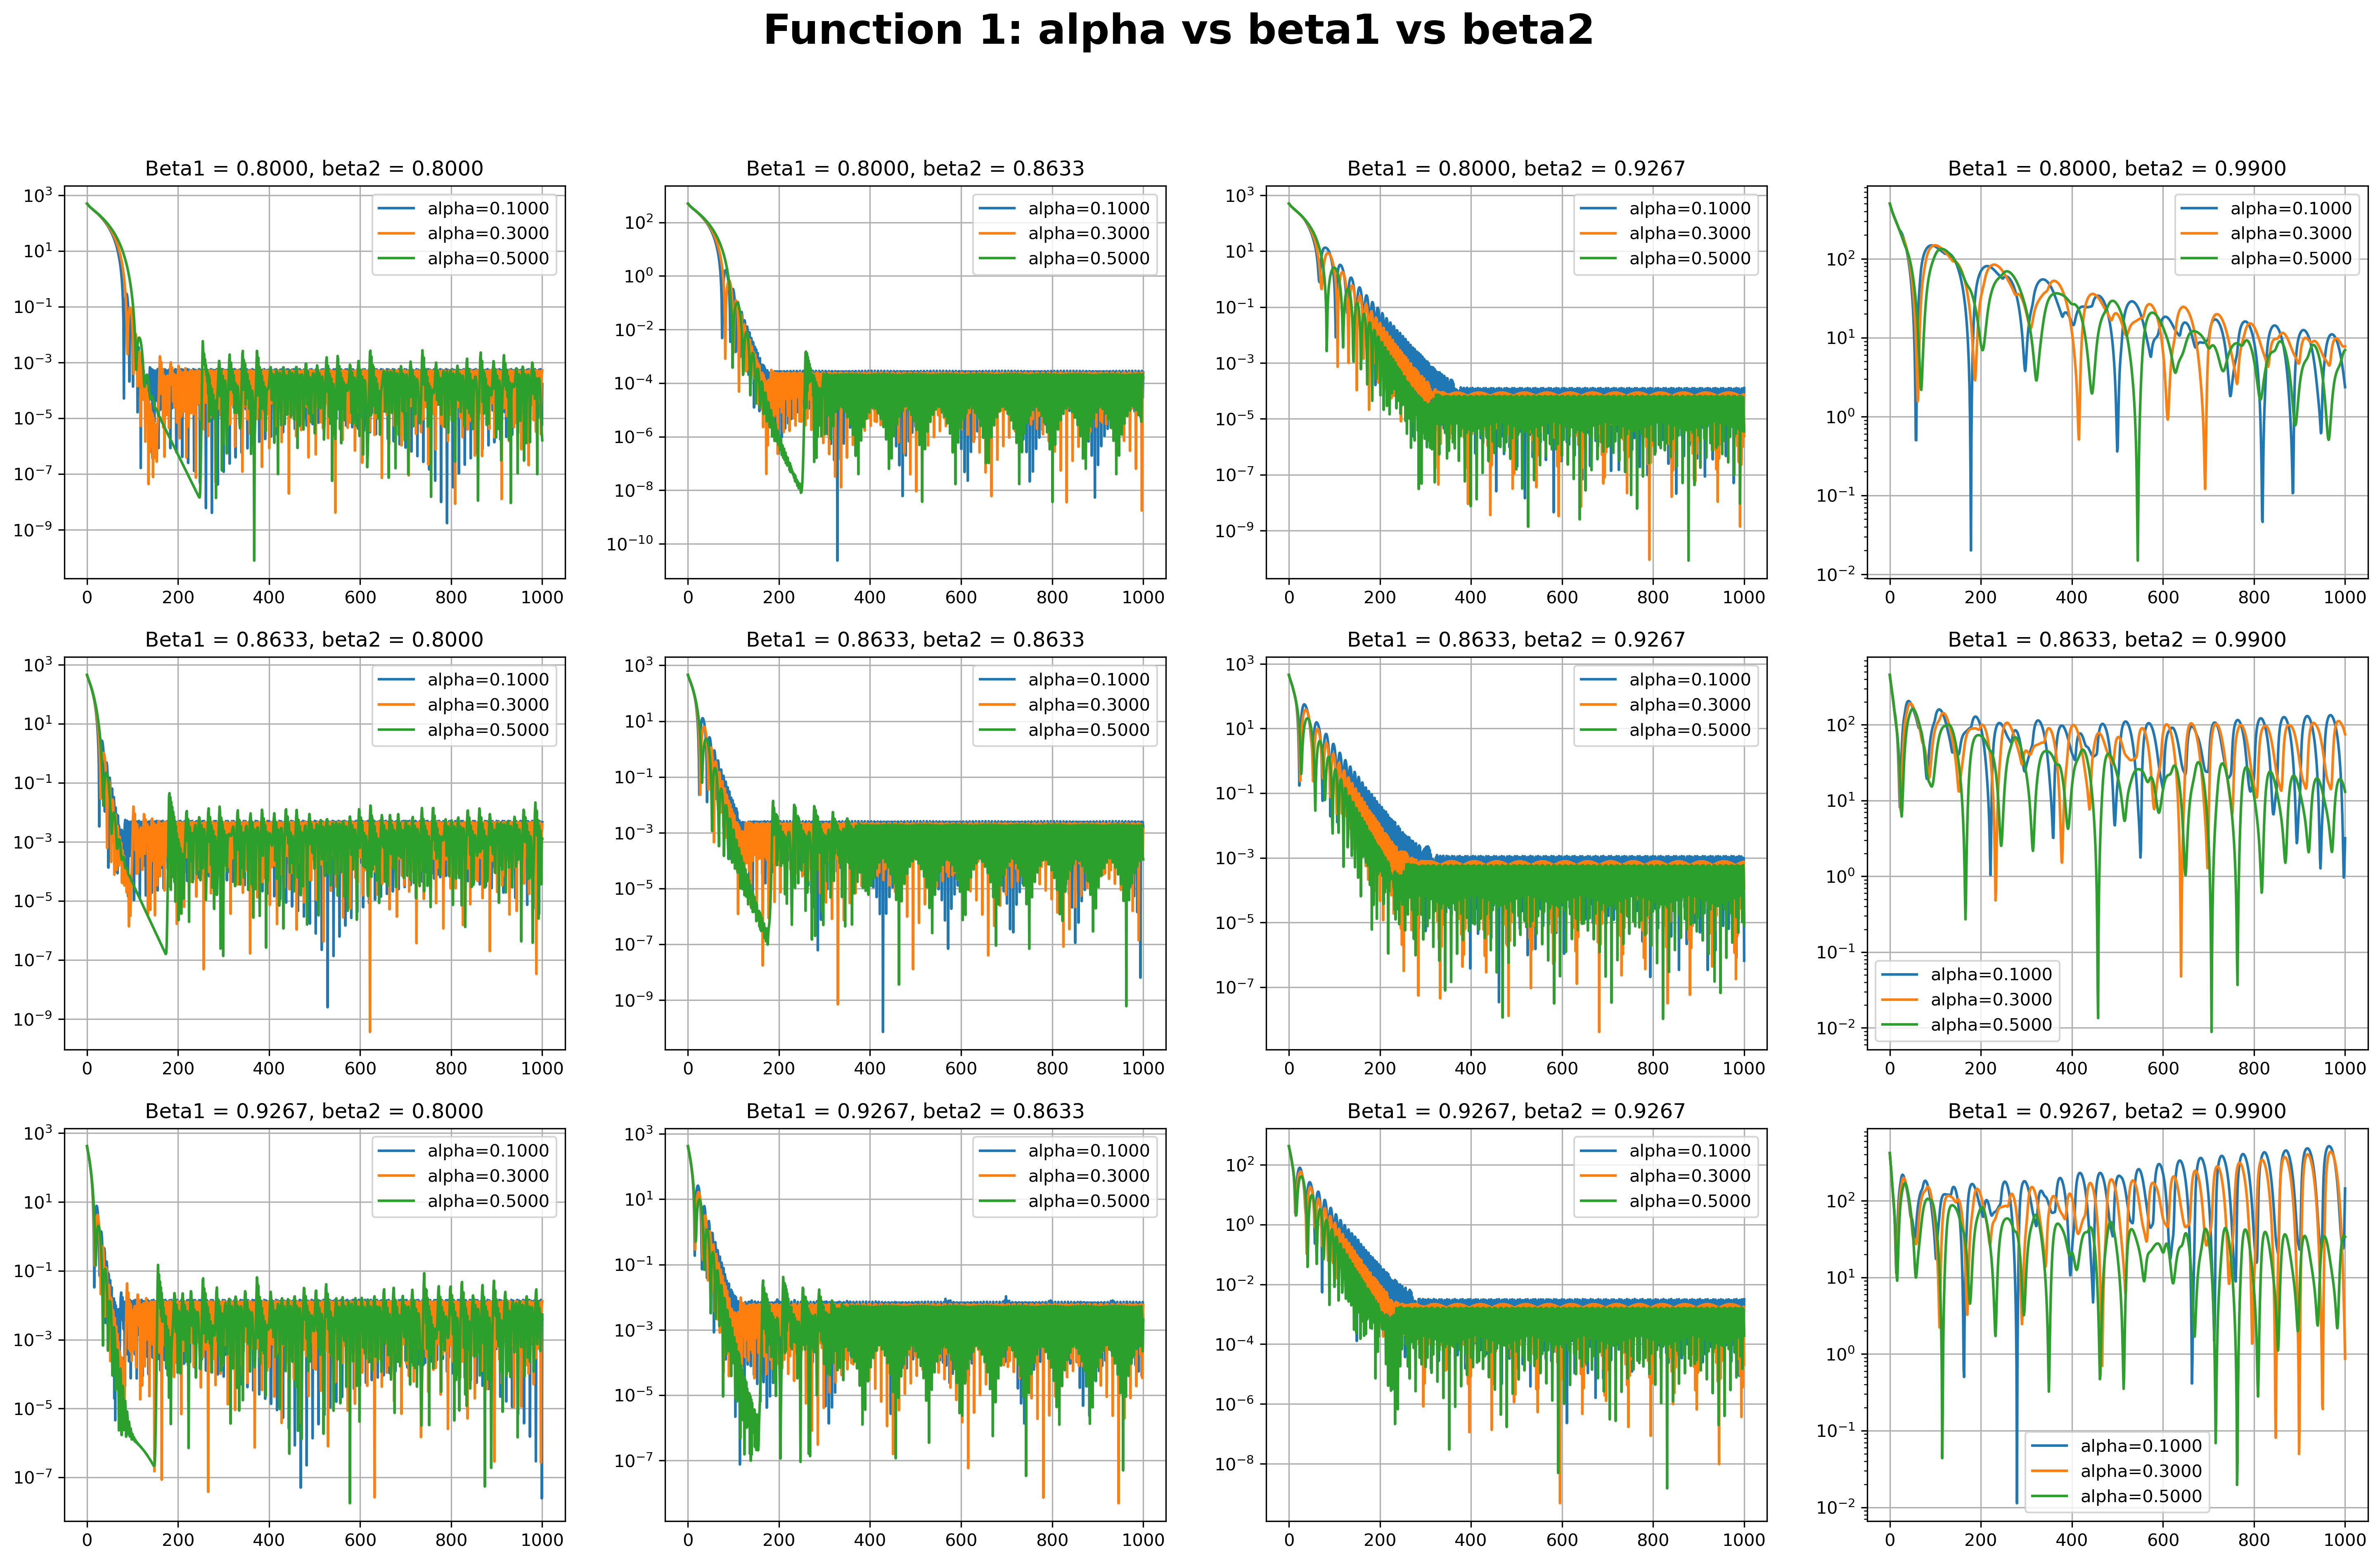

In [88]:
plt.figure(figsize=(24, 14), dpi=300)
plt.suptitle("Function 1: alpha vs beta1 vs beta2", fontsize=24, fontweight='bold')

for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.semilogy(np.linspace(0, len(f_vals_1[0][0][i]), len(f_vals_1[0][0][i])), f_vals_1[0][0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[0][1][i]), len(f_vals_1[0][1][i])), f_vals_1[0][1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[0][2][i]), len(f_vals_1[0][2][i])), f_vals_1[0][2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta1 = {beta2s[0]:0.4f}, beta2 = {beta2s[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

for i in range(4):
    plt.subplot(3, 4, i+5)
    plt.semilogy(np.linspace(0, len(f_vals_1[1][0][i]), len(f_vals_1[1][0][i])), f_vals_1[1][0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[1][1][i]), len(f_vals_1[1][1][i])), f_vals_1[1][1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[1][2][i]), len(f_vals_1[1][2][i])), f_vals_1[1][2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta1 = {beta2s[1]:0.4f}, beta2 = {beta2s[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

for i in range(4):
    plt.subplot(3, 4, i+9)
    plt.semilogy(np.linspace(0, len(f_vals_1[2][0][i]), len(f_vals_1[2][0][i])), f_vals_1[2][0][i], label=f'alpha={alphas[0]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[2][1][i]), len(f_vals_1[2][1][i])), f_vals_1[2][1][i], label=f'alpha={alphas[1]:0.4f}')
    plt.semilogy(np.linspace(0, len(f_vals_1[2][2][i]), len(f_vals_1[2][2][i])), f_vals_1[2][2][i], label=f'alpha={alphas[2]:0.4f}')
    plt.title(f'Beta1 = {beta2s[2]:0.4f}, beta2 = {beta2s[i]:0.4f}')
    plt.legend()  # Call the function to show the legend
    plt.grid(visible=True)

plt.show()

In [90]:
alphas = np.linspace(0.1, 0.5, 3) 
beta1s = np.linspace(0.8, 0.99, 4)
beta2s = np.linspace(0.8, 0.99, 4)
paths_2 = [[[adam(function2, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000)[0] for beta1 in beta1s] for beta2 in beta2s] for alpha in alphas]
f_vals_2 = [[[adam(function2, x0, y0, alpha, beta1, beta2, epsilon=1e-6, num_iters=1000)[1] for beta1 in beta1s] for beta2 in beta2s] for alpha in alphas]